Issues with TimeSeriesSplit:  

https://datascience.stackexchange.com/questions/41378/how-to-apply-stacking-cross-validation-for-time-series-data/105116#105116  

"I dont think even time series split cv is appropriate for time series prediction because it trains on those 4 blocks which capture very unique stretches of the variable's movement, in other words 4 market regimes, which are unlikely to re-appear out-of-sample. I think more randomization is needed while still retaining the order of time events. Cant bootstrap resampling with replacement be used within stacking?"

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score, mean_squared_error
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor 
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
#import branca.colormap as cm
import matplotlib.colors as colors
from sklearn.model_selection import TimeSeriesSplit
import time as time
#  Spatial packages
from shapely.geometry import Point
import geopandas as gpd
import contextily as cx
# Machine learning packages
# import xgboost as xgb
# For plotting predicted vs observed
import datashader as ds
from datashader.mpl_ext import dsshow

from Functions import *

# BlockingTimeSeriesSplit (from https://goldinlocks.github.io/Time-Series-Cross-Validation/
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits, temporal_fraction):
        self.n_splits = n_splits
        self.temporal_fraction = temporal_fraction
        
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        # Define number of samples
        n_samples = len(X)
        # Define how many samples will be in each of the folds (number of samples divided by number of splits)
        k_fold_size = n_samples // self.n_splits
        # Get an indice for every value in the dataset
        indices = np.arange(n_samples)
                
        margin = 0
        # For each of the folds
        for i in range(self.n_splits):
            # Find the start, and end (and middle?) index of the fold
            start = i * k_fold_size
            stop = start + k_fold_size
            # This is where the training data stops and testing starts
            mid = int(self.temporal_fraction * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]          

### Get the necessary data
#### Get testing and training data
Specify buffer size (as there are different versions of the data created with different buffer sizes)

In [2]:
buffer_size_m = 500
input_csv ="../Cleaned_data/FormattedDataForModelling/formatted_data_for_modelling_allsensors_{}.csv".format(buffer_size_m)
Xfull, Yfull, data_time_columns = prepare_x_y_data(input_csv)

#### Drop one version of the time variables (either cyclical or dummy versions)

In [3]:
Xfull.drop(['Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12'], axis=1, inplace = True)

#### Get as series the sensor ids and datetimes

In [4]:
sensor_ids = pd.read_csv(input_csv)['sensor_id']
datetimes = pd.read_csv(input_csv)['datetime']

### Define the error metrics for the cross-validation to return, and the parameters of the cross validation

In [6]:
error_metrics = ['neg_mean_absolute_error', 'r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error']

### Set up model pipelines

In [7]:
rf_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['rf_regressor', RandomForestRegressor(random_state = 1, n_jobs = 10)]])
models_dict = {"rf_regressor":rf_model_pipeline}

### Define cross validation method

In [24]:
btss = BlockingTimeSeriesSplit(n_splits=1, temporal_fraction=0.9)

## Run cross validation (manually)

### Manually get testing and training indices (90% of data for training, and 10% testing)

In [13]:
testing_idxs = list(range(int(len(Xfull) * 0.9), len(Xfull)))
training_idxs = list(range(0,int(len(Xfull) * 0.9)))

### Testing model manually 

In [15]:
# Lists to store the scores
mae_scores = []
rmse_scores= []
r2_scores= []
neg_mae_scores = []
# Lists to store predicetd and actual values
predicted_values=[]
observed_values = []
# List to store the datetimes
datetimes_used = []

In [16]:
# Get train and testing data for this fold
X_train, X_test = Xfull.iloc[training_idxs], Xfull.iloc[testing_idxs]
y_train, y_test = Yfull[training_idxs], Yfull[testing_idxs]

# Fit the model on the training data
rf_model_pipeline.fit(X_train, y_train)
# Use it to make predictions on the testing data, and store these
y_pred = rf_model_pipeline.predict(X_test)
predicted_values.append(y_pred)

# Store the actual values for the testing data
observed_values.append(Yfull[y_test])

# Calculate the error metrics for this fold and append to the scores lists
mae_scores.append(mean_absolute_error(y_test, y_pred))
r2_scores.append(r2_score(y_test, y_pred))
rmse_scores.append(mean_squared_error(y_test, y_pred, squared=False))
neg_mae_scores = [-score for score in mae_scores]    

### Convert list of arrays, to an array (think both cells do the same)

In [18]:
predicted_values_all = []
observed_values_all= []
for i in range(len(predicted_values)):
    for j in range(len(predicted_values[i])):
        observed_values_all.append(observed_values[i][j])
        predicted_values_all.append(predicted_values[i][j])

In [19]:
predicted_values_all = predicted_values[0]
observed_values_all= observed_values[0]

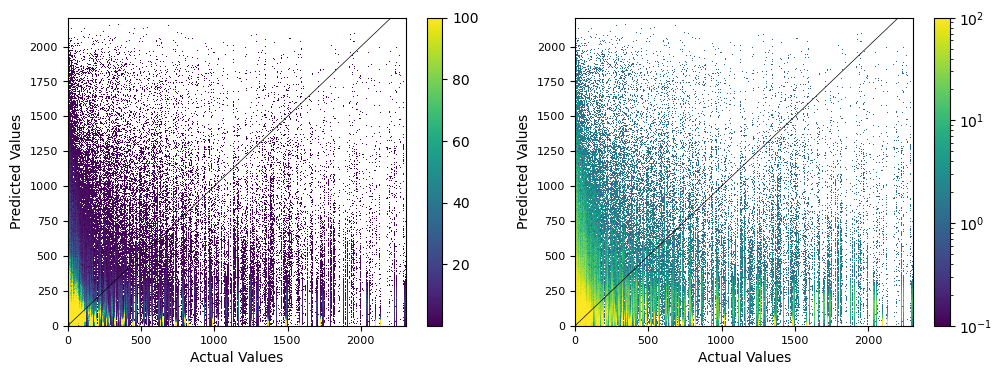

In [20]:
fig, axs = plt.subplots(ncols=2, figsize = (12,4))

# Plot with linear scale
using_datashader(axs[0], observed_values_all, predicted_values_all, 'linear')
# 1:1 line
axs[0].plot([Yfull.min(), Yfull.max()], [Yfull.min(), Yfull.max()], c='k', lw=0.5)
axs[0].set_ylabel("Predicted Values", size=10)
axs[0].set_xlabel("Actual Values", size=10)
#axs[0].set_xlim([0, 2000])
#axs[0].set_ylim([0, 2000])
axs[0].tick_params(axis='both', which='major', labelsize=8)

# Plot with log scale
using_datashader(axs[1], observed_values_all, predicted_values_all, 'log')
# 1:1 line
axs[1].plot([Yfull.min(), Yfull.max()], [Yfull.min(), Yfull.max()], c='k', lw=0.5)
axs[1].set_ylabel("Predicted Values", size=10)
axs[1].set_xlabel("Actual Values", size=10)
# axs[1].set_xlim([0, 2000])
# axs[1].set_ylim([0, 2000]);
axs[1].tick_params(axis='both', which='major', labelsize=8)

## Run cross-validation (using inbuilt packages)

In [25]:
# Dataframe to store the scores for all the models
error_metric_scores = pd.DataFrame()

for model_name, model_pipeline in models_dict.items():
    print(model_name)
    # Use cross_validate to return the error scores associated with this model and this data
    start = time()
    model_output = cross_validate(model_pipeline, Xfull, Yfull, cv=btss, scoring=error_metrics, error_score="raise")
    end = time()
    print('Ran in {} minutes'.format(round((end - start)/60),2))
    
    # Formulate the different error scores into a dataframe
    error_metrics_df =pd.DataFrame({'mae': round(abs(model_output['test_neg_mean_absolute_error'].mean()),2), 
                  'mape': round(abs(model_output['test_neg_mean_absolute_percentage_error'].mean()),2),
                  'r2': round(abs(model_output['test_r2'].mean()),2), 
                  'rmse': round(abs(model_output['test_neg_root_mean_squared_error'].mean()),2)},
                 index =[model_name])
        
    # Add evaluation metric scores for this model to the dataframe containing the metrics for each model
    error_metric_scores = error_metric_scores.append(error_metrics_df)
    # Save error scores for this distance to file
    # error_metrics_df.to_csv('Results/CV/ComparingModels/{}_{}m_error_metric_scores.csv'.format(model_name,buffer_size_m),index=False)    

# Save dataframes of error metrics for each buffer distance 
# error_metric_scores.to_csv('Results/CV/ComparingModels/comparingmodels_error_metric_scores.csv')   

rf_regressor
Ran in 25 minutes


### Print table showing error metrics associated with each model

In [26]:
error_metric_scores

,mae,mape,r2,rmse
rf_regressor,154.52,5.230985e+15,0.51,306.09


In [ ]:
# #### Run cross_val_predict to get predictions
# start = time()
# predictions = cross_val_predict(rf_model_pipeline, Xfull, Yfull,cv=btss)
# end = time()
# print('Ran cross_val_predict in {} minutes'.format(round((end - start)/60),2))
# # Convert to a dataframe
# predictions_df=pd.DataFrame(predictions)
# # Store the predictions
# # predictions_df.to_csv('Results/CV/ModelEvaluation_WithCV/predictions_RF_{}.csv'.format(buffer_size_m),index=False)   